In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import itertools
from astropy.table import Table
import matplotlib as mpl
import os

plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

In [2]:
os.chdir('../')

In [3]:
import make_dictionaries

question_dictionary = make_dictionaries.questions
debiased_data = Table.read('../fits/full_sample_debiased.fits')
print('Loaded galaxy data...')

Loaded galaxy data...


In [31]:
in_volume_limit = debiased_data['in_volume_limit'] == True
vl_data = debiased_data[in_volume_limit]

In [45]:
question_keys = question_dictionary.keys()

answerlabels = []
answer_names = []
questions = []
questionlabels = []

for Q in question_keys:
    questions.append(Q)
    questionlabels.append(question_dictionary[Q]['questionlabel'])
questions.sort()

for Q in questions:
    answerlabels.append(question_dictionary[Q]['answerlabels'])
    answer_names.append(question_dictionary[Q]['answers'])

In [46]:
def optimise_order(data, col_per_plot=2, col_per_gap=1, max_perms=1000):
    nq = len(data)
    nas = np.array([len(q) for q in data])
    max_on_row = max(nas) * col_per_plot + col_per_gap
    nrow_best = nq
    orders = itertools.permutations(range(nq))
    for i_perm, order in enumerate(orders):
        if i_perm >= max_perms:
            break
        nrow = 0
        ncol = 0
        count_on_row = 0
        positions = np.zeros((nq, 2), np.int)
        order = np.array(order)
        for iq in order:
            na = nas[iq]
            count_on_row += na * col_per_plot
            if count_on_row > max_on_row:
                nrow += 1
                ncol = 0
                count_on_row = na * col_per_plot
            count_on_row += col_per_gap
            positions[iq] = (nrow, ncol)
            ncol = count_on_row
        if nrow < nrow_best:
            nrow_best = nrow
            order_best = order
            positions_best = positions
    return positions_best, order_best, nrow_best + 1, max_on_row

In [47]:
col_per_plot = 1
col_per_gap = 1
positions, order, nrow, ncol = optimise_order(answerlabels, col_per_plot, col_per_gap)

In [65]:
def reduce_sample(full_data,questions,question,p_cut=0.5,N_cut=5,normalised_values=True,dataset='w13'):
    '''For a given question, get thresholded data'''
    # Get the reference sample from the previous data:
    
    previous_q = questions[question]['pre_questions']
    previous_a = questions[question]['pre_answers']

    if normalised_values == True:
        suffix = '_debiased_rh'#_normalised'
    else:
        suffix = '_debiased_rh_normalised'
    
    if previous_q != None:
        
        p_col = np.ones(len(full_data))
        
        for m in range(len(previous_q)):
            p_col = p_col*(full_data[previous_q[m] + '_' + previous_a[m] + suffix])
        N_col = (full_data[previous_q[-1] + '_' + previous_a[-1] + '_count'])
        
        select = (p_col > p_cut) & (N_col >= N_cut)
        data_reduced = full_data[select]
        print('{}/{} galaxies with p>{} and N>={}.'.format(len(data_reduced),
                                                          len(full_data),p_cut,N_cut))
    
    else:
        data_reduced = full_data.copy()
        print('Primary question, so all {} galaxies used.'.format(len(data_reduced)))
        
        select = np.ones(len(data_reduced)) == 1
    
    return data_reduced,select


def plot_histogram(data,question,answer,ax,N_bins=8,logy=True,method='fit'):
    
    high_z = (data['REDSHIFT_1'] > 0.08) & (data['REDSHIFT_1'] <= 0.085)
    low_z = (data['REDSHIFT_1'] > 0.03) & (data['REDSHIFT_1'] <= 0.035)
    hist_bins = np.linspace(0,1,N_bins+1)
        
    s_data,select = reduce_sample(data,question_dictionary,question,dataset=None)
            
    ref = data[question + '_' + answer + '_weighted_fraction'][(low_z) & (select)]
    raw = data[question + '_' + answer + '_weighted_fraction'][(high_z) & (select)]
    w13 = data[question + '_' + answer + '_debiased'][(high_z) & (select)]
    h16 = data[question + '_' + answer + '_debiased_rh'][(high_z) & (select)]
        
    ax.set_xticks([0.2,0.4,0.6,0.8])
            
    _ = ax.hist(ref,bins=hist_bins,normed=True,
                histtype='stepfilled',linewidth=0,color='b',alpha=0.3,
                label='$0.03<z\leq 0.035$ (raw)')
    _ = ax.hist(raw,bins=hist_bins,normed=True,
                histtype='step',linewidth=3,color='k',linestyle='solid',
                label='$0.08<z\leq 0.085$ (raw)')
    _ = ax.hist(w13,bins=hist_bins,normed=True,
                histtype='step',linewidth=5,color='r',linestyle='dotted',
                label='$0.08<z\leq 0.085$ (W13)')
    _ = ax.hist(h16,bins=hist_bins,normed=True,
                histtype='step',linewidth=4,color='r',linestyle='dashed',
                label='$0.08<z\leq 0.085$ (this paper)')
        
    if logy == True:
        ax.set_yscale('log')
            #ax.set_yticks([])

    return None

Primary question, so all 62220 galaxies used.
Primary question, so all 62220 galaxies used.
Primary question, so all 62220 galaxies used.
39054/62220 galaxies with p>0.5 and N>=5.
39054/62220 galaxies with p>0.5 and N>=5.
32017/62220 galaxies with p>0.5 and N>=5.
32017/62220 galaxies with p>0.5 and N>=5.
32017/62220 galaxies with p>0.5 and N>=5.
32017/62220 galaxies with p>0.5 and N>=5.
32017/62220 galaxies with p>0.5 and N>=5.
32017/62220 galaxies with p>0.5 and N>=5.
32017/62220 galaxies with p>0.5 and N>=5.
32017/62220 galaxies with p>0.5 and N>=5.
Primary question, so all 62220 galaxies used.
Primary question, so all 62220 galaxies used.
22255/62220 galaxies with p>0.5 and N>=5.
22255/62220 galaxies with p>0.5 and N>=5.
22255/62220 galaxies with p>0.5 and N>=5.
8605/62220 galaxies with p>0.5 and N>=5.
8605/62220 galaxies with p>0.5 and N>=5.
8605/62220 galaxies with p>0.5 and N>=5.
8605/62220 galaxies with p>0.5 and N>=5.
8605/62220 galaxies with p>0.5 and N>=5.
8605/62220 galaxies

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in greater


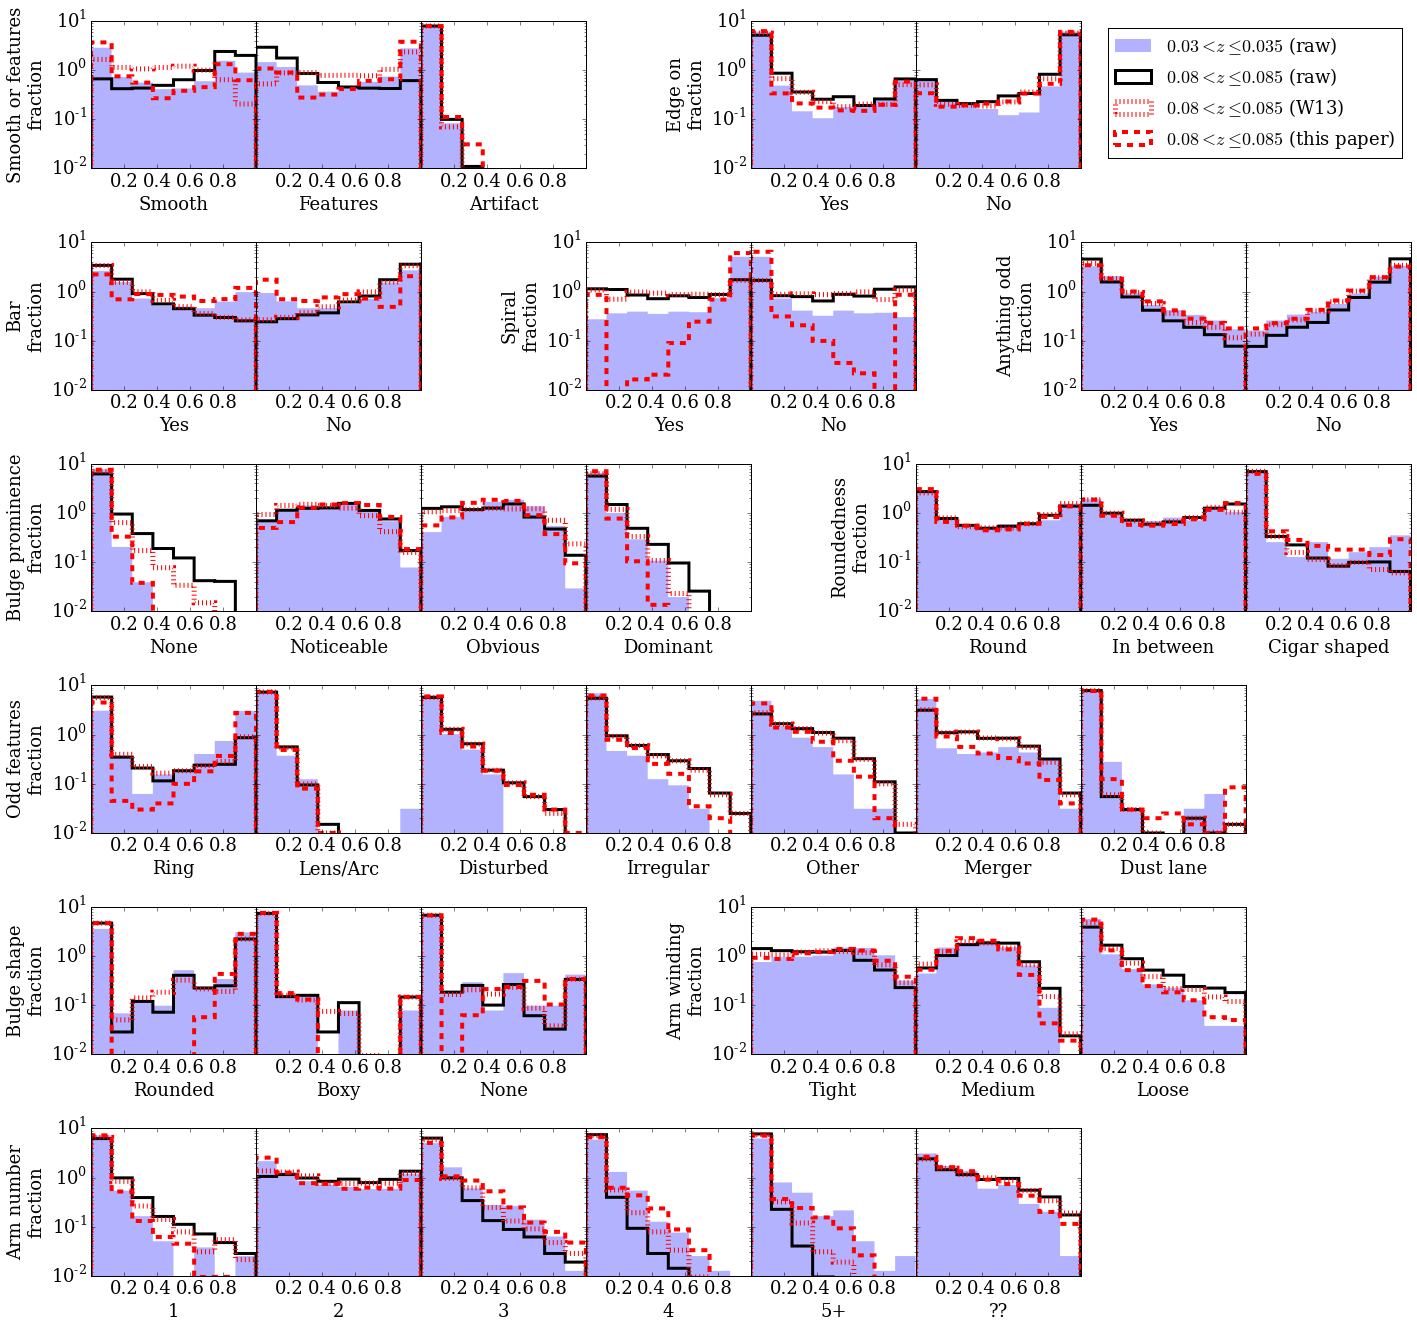

In [81]:
fig = plt.figure(figsize=(20, nrow/ncol*25))
gs = gridspec.GridSpec(nrow, ncol, wspace=0)
master_ax = None
for iq, (r, c), answers in zip(range(len(answerlabels)), positions, answerlabels):
    for ia, a in enumerate(answers):
        ax = fig.add_subplot(gs[r, c : c + col_per_plot],
                             sharex=master_ax, sharey=master_ax)
        if master_ax is None:
            master_ax = ax
        ax.set_xlabel(a)
        ax.xaxis.set_major_locator(MaxNLocator(5, prune='both'))
        plot_histogram(vl_data,questions[iq],answer_names[iq][ia],ax)
        if ia > 0:
            plt.setp(ax.get_yticklabels(), visible=False)
        else:
            ax.set_ylabel('{}\nfraction'.format(question_dictionary[questions[iq]]['questionlabel']))
        c += col_per_plot
        
        if (iq == 1) & (ia == 1):
            #plot_histogram(vl_data,questions[iq],answer_names[iq][ia],ax)
            ax.legend(fontsize=18,
                      bbox_transform = plt.gcf().transFigure,
                      bbox_to_anchor = (-0.013,-0.0225,1,1))
        
fig.tight_layout()

plt.savefig('Plotting_codes/figures/all_histograms.pdf',dpi=300)